# Structured Random Phase Retrieval

<a target="_blank" href="https://colab.research.google.com/github/chromatix-team/chromatix/blob/main/docs/examples/structured_random_phase_retrieval.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# If in Colab, install Chromatix. Don't forget to select a GPU!
!pip install --upgrade pip
!pip install git+https://github.com/chromatix-team/chromatix.git

In this example, we will implement the structured random phase retrieval model proposed by [1](#2025hustructured). In this paper, a new forward model for the inverse problem of phase retrieval $\mathbf{y}=| \mathbf{A} \mathbf{x}|^2$ is designed as:

$$ \mathbf{A} = \mathbf{S} \prod_{i=1}^N (\mathbf{T}_i \mathbf{D}_i) [\mathbf{T}_0] \mathbf{O},$$

where $\mathbf{T}_i$ is a structured transform, $\mathbf{D}_i$ is a random diagonal matrix. The "0.5 layer" $\mathbf{T}_0$ is optional at the end of the transform sequence. The subsampling and oversampling operations $\mathbf{S}$ and $\mathbf{O}$ are done through edge-trimming and zero-padding. By alternately applying structured transforms and random diagonal matrices, this forward model is able to achieve the same reconstruction performance as classical i.i.d. random matrices, while reducing computational complexity to $\mathcal{O}(n \text{log} n)$ instead of $\mathcal{O}(n^2)$.

In the following, we will:

1. Implement the structured random model in chromatix.
2. Create a test field and visualize the measurements.
3. Implement spectral methods introduced in [2](#2019luooptimal) to reconstruct the field from the measurements.
4. Running gradient descent through AutoDiff on the output of spectral methods to improve the performance.

<a id="2025hustructured">1.</a> Hu, Z., Tachella, J., Unser, M., & Dong, J. (2025, April). Structured random model for fast and robust phase retrieval. In ICASSP 2025-2025 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 1-5). IEEE.

<a id="2019luooptimal">2.</a> Luo, W., Alghamdi, W., & Lu, Y. M. (2019). Optimal spectral initialization for signal recovery with applications to phase retrieval. IEEE Transactions on Signal Processing, 67(9), 2347-2356.

In [1]:
import math

import equinox
import jax
import jax.numpy as jnp
import numpy as np
import optax
import skimage
from jax import Array
from matplotlib import pyplot as plt

import chromatix.utils as cu

In [2]:
# helper function to show amplitude and phase of a complex field
def show_amplitude_and_phase(
    amplitude: jnp.ndarray, phase: jnp.ndarray, unit: bool = False
):
    fig, axes = plt.subplots(nrows=1, ncols=2, dpi=300)
    ax = axes[0]
    if unit:
        ax.imshow(amplitude, cmap="gray", vmin=0.99, vmax=1.01)
    else:
        ax.imshow(amplitude, cmap="gray", vmin=amplitude.min(), vmax=amplitude.max())
    ax.axis("off")
    ax.set_title("amplitude")
    ax = axes[1]
    ax.imshow(phase, cmap="gray", vmin=-math.pi, vmax=math.pi)
    ax.axis("off")
    ax.set_title("phase")

We implement the model as an `equinox.Module` to jit its forward and adjoint operators later.

In [3]:
class StructuredRandomPhaseRetrieval(equinox.Module):
    input_shape: tuple[int, int, int, int, int]
    middle_shape: tuple[int, int, int, int, int]
    output_shape: tuple[int, int, int, int, int]
    num_layers: int | float
    half: bool
    mode: str
    diffuser_phases: Array

    def __init__(
        self, input_shape: tuple, output_shape: tuple, num_layers: int | float
    ):
        assert num_layers * 2 == math.floor(num_layers * 2), (
            "Number of layers must be an integer or half-integer."
        )
        assert (
            input_shape[0] == output_shape[0] and input_shape[-1] == output_shape[-1]
        ), "Batch and channel dimensions must match in input and output shapes."
        assert input_shape[1] % 2 == input_shape[2] % 2 == 0, (
            "Input shape must be square and even in width and height."
        )
        assert output_shape[1] % 2 == output_shape[2] % 2 == 0, (
            "Output shape must be square and even in width and height."
        )

        if num_layers - math.floor(num_layers) > 0:
            self.half = True
        else:
            self.half = False

        if input_shape[1] <= output_shape[1] and input_shape[2] <= output_shape[2]:
            self.mode = "oversampling"
            self.middle_shape = output_shape
        elif input_shape[1] >= output_shape[1] and input_shape[2] >= output_shape[2]:
            self.mode = "undersampling"
            self.middle_shape = input_shape
        else:
            raise ValueError(
                "Dimension changes from input to output are not consistent in width and height."
            )

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.num_layers = num_layers

        # * the diffusers have uniform random phases in (-pi, pi]
        self.diffuser_phases = (
            2
            * np.pi
            * jax.random.uniform(
                shape=(math.floor(num_layers), *self.middle_shape),
                minval=0,
                maxval=1,
                key=jax.random.PRNGKey(0),
            )
        )
        # * alternatively, they can have uniform random phases in {-pi/2, 0, pi/2, pi}
        self.diffuser_phases = (
            jnp.pi
            / 2
            * jax.random.choice(
                jax.random.PRNGKey(0),
                jnp.array([-1, 0, 1, 2]),
                shape=(math.floor(num_layers), *self.middle_shape),
                replace=True,
            )
        )

    def linear(self, x):
        # * returns Ax
        assert x.shape == self.input_shape, (
            f"Input shape {x.shape} does not match expected input shape {self.input_shape}."
        )

        if self.mode == "oversampling":
            x = cu.center_pad(
                x,
                (
                    0,
                    (self.middle_shape[1] - self.input_shape[1]) // 2,
                    (self.middle_shape[2] - self.input_shape[2]) // 2,
                    0,
                    0,
                ),
            )

        if self.half:
            x = jnp.fft.fft2(x, axes=(1, 2), norm="ortho")

        for i in range(math.floor(self.num_layers)):
            # x = cf.phase_change(x, self.diffuser_phases[i])
            x = x * jnp.exp(1j * self.diffuser_phases[i])
            x = jnp.fft.fft2(x, axes=(1, 2), norm="ortho")

        if self.mode == "undersampling":
            x = cu.center_crop(
                x,
                (
                    0,
                    (self.middle_shape[1] - self.output_shape[1]) // 2,
                    (self.middle_shape[2] - self.output_shape[2]) // 2,
                    0,
                    0,
                ),
            )

        return x

    def forward(self, x):
        # * returns |Ax|^2
        # return self.linear(x).intensity
        return jnp.abs(self.linear(x)) ** 2

    def adjoint(self, y):
        # * returns A^H y
        assert y.shape == self.output_shape, (
            f"Output shape {y.shape} does not match expected output shape {self.output_shape}."
        )

        if self.mode == "undersampling":
            y = cu.center_pad(
                y,
                (
                    0,
                    (self.middle_shape[1] - self.output_shape[1]) // 2,
                    (self.middle_shape[2] - self.output_shape[2]) // 2,
                    0,
                    0,
                ),
            )

        for i in range(math.floor(self.num_layers) - 1, -1, -1):
            y = jnp.fft.ifft2(y, axes=(1, 2), norm="ortho")
            y = y * jnp.exp(-1j * self.diffuser_phases[i])

        if self.half:
            y = jnp.fft.ifft2(y, axes=(1, 2), norm="ortho")

        if self.mode == "oversampling":
            y = cu.center_crop(
                y,
                (
                    0,
                    (self.middle_shape[1] - self.input_shape[1]) // 2,
                    (self.middle_shape[2] - self.input_shape[2]) // 2,
                    0,
                    0,
                ),
            )

        return y

We create a 2-layer model $\mathbf{T}\mathbf{D}\mathbf{T}\mathbf{D}$ with input field size `(1024, 1024)`.

In [4]:
size = 1024

model = StructuredRandomPhaseRetrieval(
    input_shape=(1, size, size, 1, 1),
    output_shape=(1, 2 * size, 2 * size, 1, 1),
    num_layers=2,
)

We use the cameraman image as the phase information of the field to be constructed. The magnitudes are all 1s. 

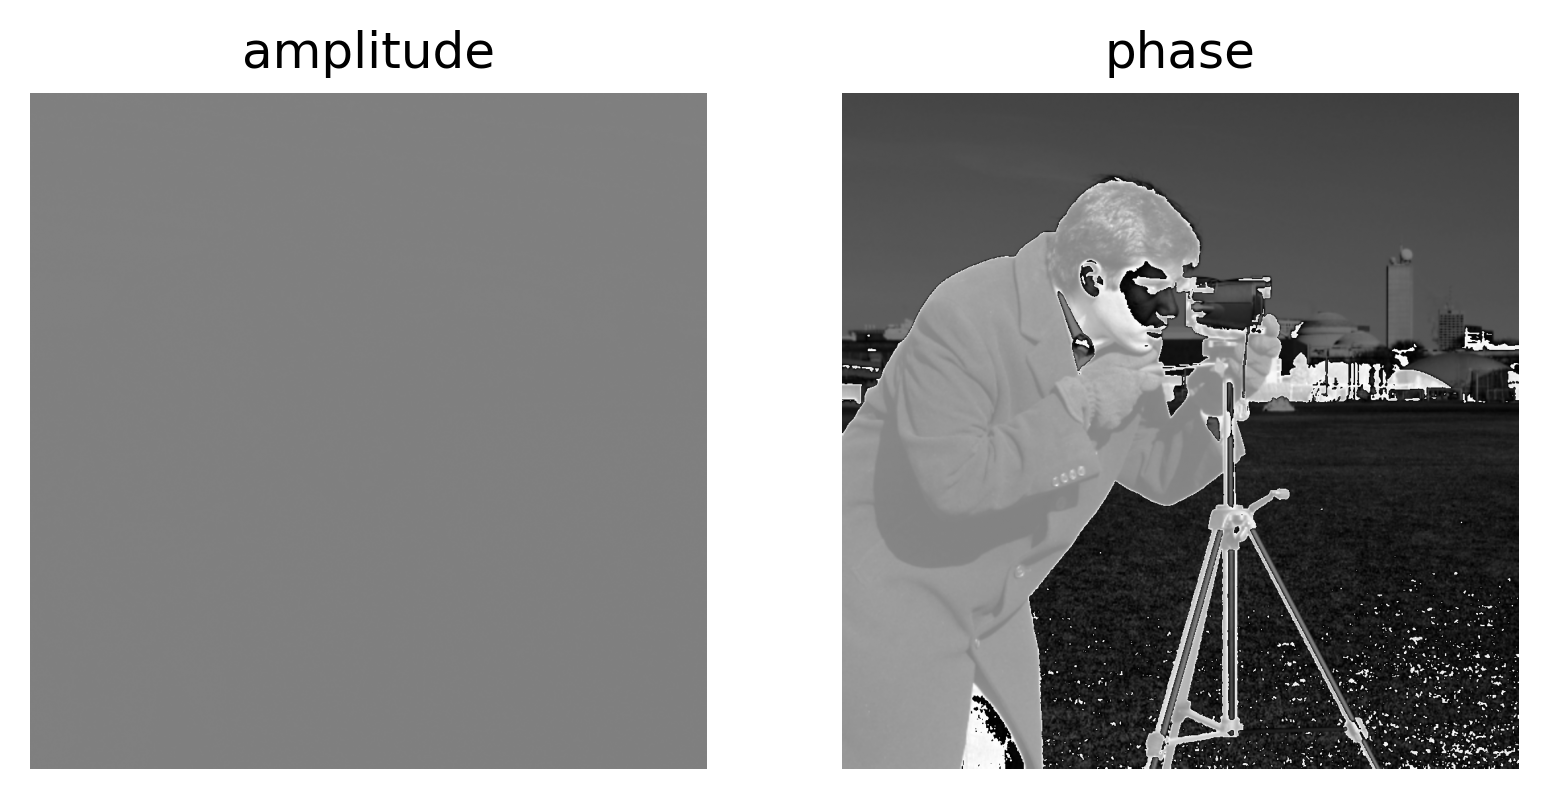

In [5]:
phase = skimage.data.camera().astype("float")
phase = skimage.transform.resize(phase, (size, size))
phase = phase / jnp.max(phase)
phase = jnp.expand_dims(phase, axis=(0, -2, -1))
x = jnp.exp(1j * 2 * np.pi * phase).to_device(jax.devices()[0])
show_amplitude_and_phase(
    np.abs(x[0, :, :, 0, 0]), np.angle(x[0, :, :, 0, 0]), unit=True
)

We use `equinox.filter_jit` to jit the linear and adjoint operators of the model, which are called thousands of times during reconstruction and are the bottleneck for time complexity.

In [6]:
linear_jitted = equinox.filter_jit(model.linear)
adjoint_jitted = equinox.filter_jit(model.adjoint)

We pass the field into the model to acquire the measurements. The measurements appear to be a random intensity field due to the random nature of the model.

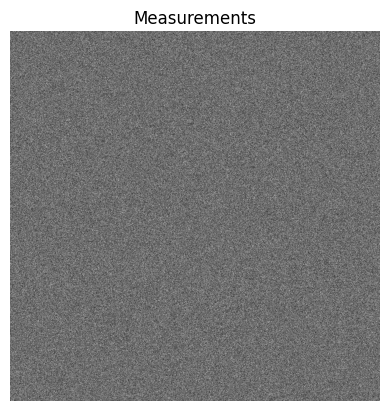

In [7]:
# to assert A^H A = I
assert jnp.allclose(adjoint_jitted(linear_jitted(x)), x, atol=1e-5), (
    "Adjoint operation does not match original input."
)
y = model.forward(x)
plt.imshow(y[0, :, :, 0, 0], cmap="gray", vmin=0, vmax=0.5)
plt.axis("off")
plt.title("Measurements")
plt.show()

To reconstruct the signal, we use spectral methods which computes the principal eigenvector of the covariance matrix $\mathbf{M}$ constructed from the sensing matrix $\mathbf{A}$ and measurements $\mathbf{y}$:

$$ \mathbf{M} = \mathbf{A}^\text{H} \text{diag}({\frac{\mathcal{T}(\mathbf{y})}{m}}) \mathbf{A},$$

where $m$ is the dimension of the measurements $\mathbf{y}$ and $\mathcal{T}(y) = 1 - 1/y$ is the optimal preprocessing function for the noiseless random matrix configuration.

Spectral methods are approximately solved by power iteration, which computes $\mathbf{x}_{t+1} = \mathbf{M}\mathbf{x}_{t}$ iteratively starting with a random $\mathbf{x}_0$. A bias matrix $-2 \lambda \mathbf{I}$ with $\lambda < 0$ is added to $\mathbf{M}$ to accelerate convergence with the corresponding change in the preprocessing function $\mathcal{T}$.

In [8]:
def spectral_methods(
    y,
    model: StructuredRandomPhaseRetrieval,
    num_iterations: int = 400,
    lambd: float = -5.0,
    jitted: bool = True,
):
    if jitted:
        linear_func = linear_jitted
        adjoint_func = adjoint_jitted
    else:
        linear_func = model.linear
        adjoint_func = model.adjoint
    x = jnp.exp(1j * 2 * np.pi * np.random.rand(*model.input_shape))

    y = y / jnp.mean(y)

    amplitude_mask = jnp.maximum(1 - 1 / y, lambd)

    for _ in range(num_iterations):
        x_new = adjoint_func(amplitude_mask * linear_func(x))
        x_new = x_new - 2 * lambd * x
        x_new = x_new / jnp.linalg.norm(x_new.flatten())
        x = x_new

    return x

We run spectral methods for 800 iterations using the measurements to reconstruct the field. Using the jitted version of the linear and adjoint operators provides roughly a 50% time boost.

In [ ]:
%timeit -n 1 -r 1 spectral_methods(y, model, num_iterations=800, lambd=-5.0, jitted=False)

6.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
%timeit -n 1 -r 1 spectral_methods(y, model, num_iterations=800, lambd=-5.0, jitted=True)

3.11 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
x_spec = spectral_methods(y, model, num_iterations=800, lambd=-5.0, jitted=True)

We use cosine similarity $\frac{|\mathbf{x}^\text{H} \hat{\mathbf{x}}|}{\|\mathbf{x}\| \cdot \|\hat{\mathbf{x}}\|}$ to benchmark the performance, with 0 indicating an uncorrelated guess and 1 a perfect recovery.

In [15]:
def cosine_similarity(x, y):
    x = x.flatten()
    y = y.flatten()
    dot_product = jnp.sum(x * jnp.conj(y))
    norm_x = jnp.sqrt(jnp.sum(jnp.abs(x) ** 2))
    norm_y = jnp.sqrt(jnp.sum(jnp.abs(y) ** 2))

    return jnp.abs(dot_product) / (norm_x * norm_y)

As can be seen from the visualization, spectral methods by itself provides a decent reconstruction. Note a global phase shift may be present due to the nonlinearity of the model.

Cosine similarity: 0.8618080019950867


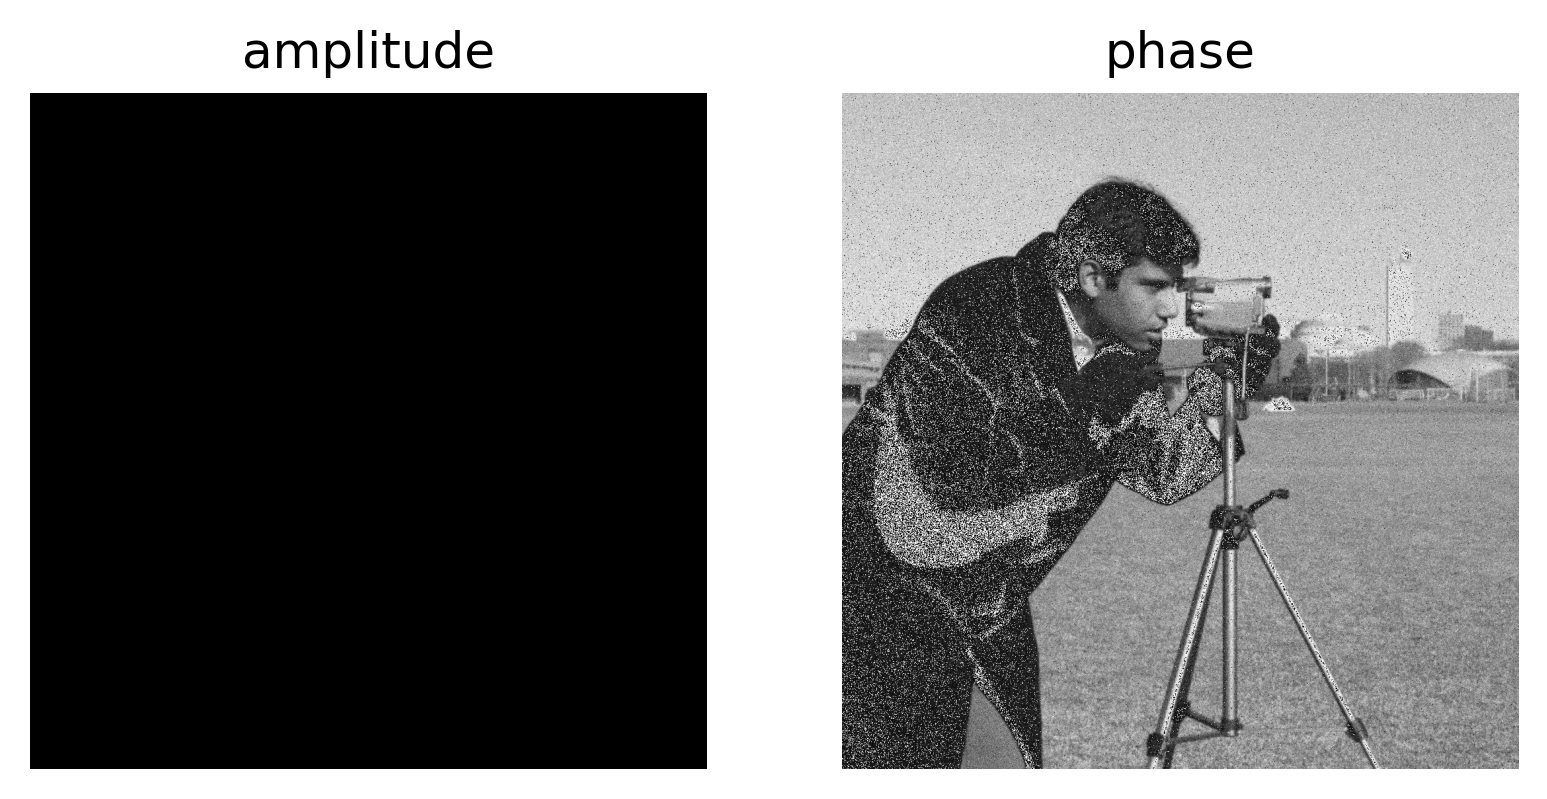

In [16]:
print("Cosine similarity:", cosine_similarity(x_spec, x).item())
show_amplitude_and_phase(
    np.abs(x_spec[0, :, :, :, 0]), np.angle(x_spec[0, :, :, :, 0]), unit=True
)

In the following cells, we run gradient descent initialized with the spectral methods' solution to further improve the results. The gradient is computed automatically by AutoDiff.

In [17]:
parameters = x_spec
optimizer = optax.adam(1e-1)
opt_state = optimizer.init(parameters)

In [18]:
def loss_fn(parameters, measurements):
    # * l2 loss
    simulated = model.forward(parameters)
    return jnp.mean((simulated - measurements) ** 2)

In [19]:
def step(parameters, opt_state, measurements):
    loss, grads = jax.value_and_grad(loss_fn)(parameters, measurements)
    updates, opt_state = optimizer.update(grads.conj(), opt_state)
    parameters = optax.apply_updates(parameters, updates)
    return loss, parameters, opt_state

The gradient descent converges in 200 iterations.

In [20]:
losses = []
for i in range(200):
    loss, parameters, opt_state = step(parameters, opt_state, y)
    losses.append(np.array(loss))
    if i % 10 == 0:
        print(f"iteration {i + 1} loss = {loss}")

iteration 1 loss = 0.1250183880329132
iteration 11 loss = 0.0618647038936615
iteration 21 loss = 0.0174564179033041
iteration 31 loss = 0.008386792615056038
iteration 41 loss = 0.003262251615524292
iteration 51 loss = 0.001464329194277525
iteration 61 loss = 0.0006367773748934269
iteration 71 loss = 0.00028100726194679737
iteration 81 loss = 0.00012329965829849243
iteration 91 loss = 5.3806579671800137e-05
iteration 101 loss = 2.335794488317333e-05
iteration 111 loss = 1.0081912478199229e-05
iteration 121 loss = 4.326812813815195e-06
iteration 131 loss = 1.8429241208650637e-06
iteration 141 loss = 7.788770517436205e-07
iteration 151 loss = 3.2552966899856983e-07
iteration 161 loss = 1.3422163647192065e-07
iteration 171 loss = 5.4424663886720737e-08
iteration 181 loss = 2.1628284940788944e-08
iteration 191 loss = 8.398782114227288e-09


The reconstruction is further improved and achieves perfect recovery up to a global phase shift, with a cosine similarity of 1.

Cosine similarity: 0.9999998807907104


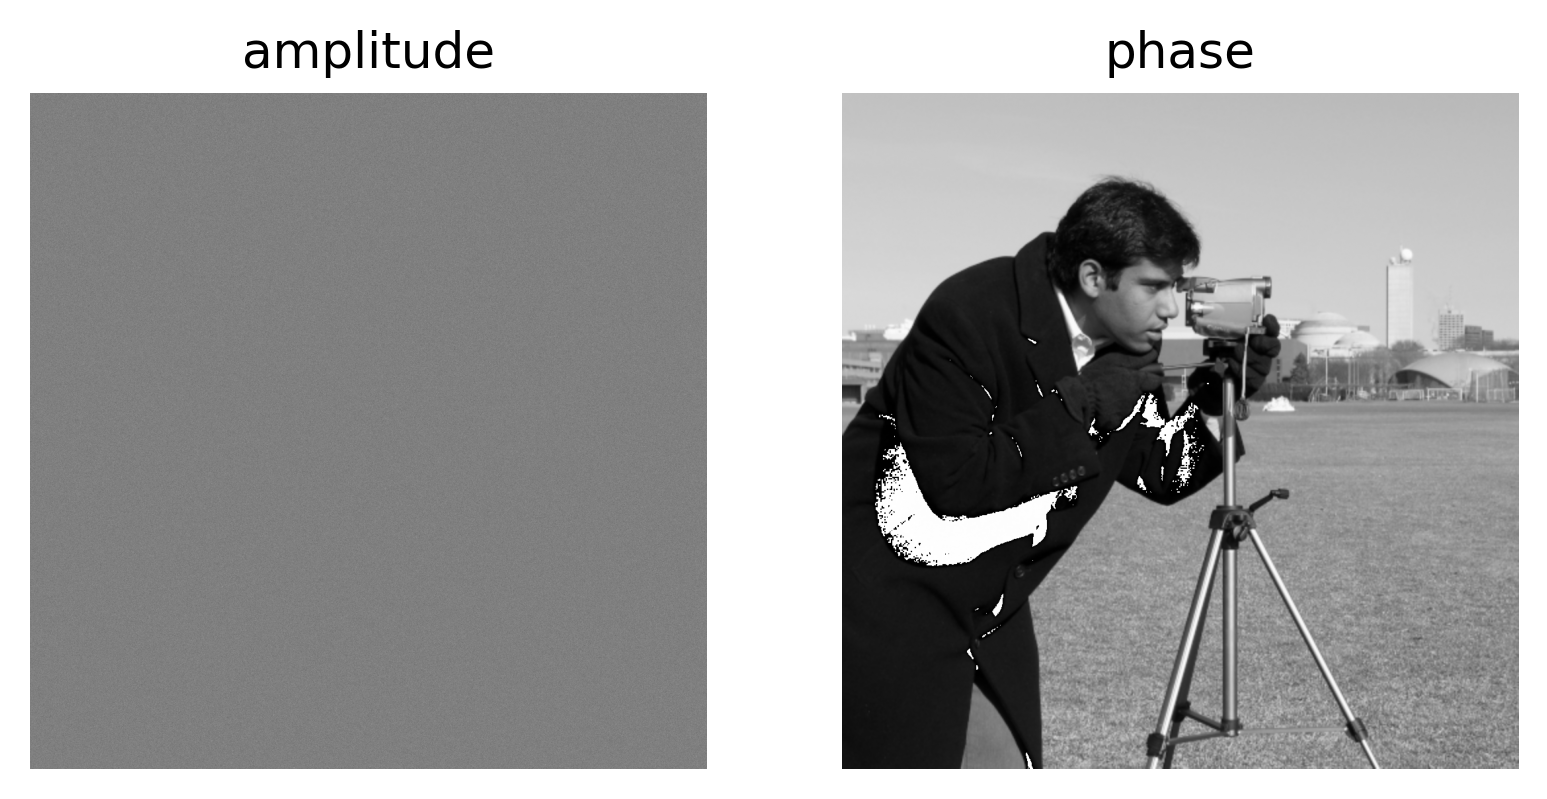

In [21]:
x_gd_spec = parameters
print("Cosine similarity:", cosine_similarity(x_gd_spec, x).item())
show_amplitude_and_phase(
    np.abs(x_gd_spec[0, :, :, :, 0]), np.angle(x_gd_spec[0, :, :, :, 0]), unit=True
)